## Import necessary packages 

In [65]:
# Python modules 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
import pandas as pd
import importlib
from numpy import loadtxt
from matplotlib import gridspec # for the contour plots
from cvxopt import matrix, solvers
from tkinter.filedialog import askopenfilename

# pyDRTtools' modules
import pyDRTtools
import pyDRTtools.basics as basics # pyDRTtools functions
import pyDRTtools.GUI as UI

In [66]:
## for nice plot
# options for the plots
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
%matplotlib inline

### 1. Analysis of a single EIS spectrum generated with the Cole-Cole model

#### 1.1 Load the data

In [67]:
file_path = askopenfilename(title="Select CSV files", filetypes=[("CSV files", "*.csv")])
df = pd.read_csv(file_path)
N_freqs = df.shape[0]
print(N_freqs)
freq_vec = np.flip(df['Frequency (Hz)'].values)
Z_exp = np.flip(df['Zre (ohms)'].values + 1j*df['Zim (ohms)'].values)
# freq_vec = np.flip(df['Freq'].values)
# Z_exp = np.flip(df['Real'].values + 1j*df['Imag'].values)

64


#### 1.2 Define the range of timescales

In [68]:
# N_taus = 64
# log_tau_min = -6  
# log_tau_max = 2
N_taus = N_freqs
log_tau_min = -4  
log_tau_max = 4   
tau_vec = np.logspace(log_tau_min, log_tau_max, num = N_taus, endpoint=True)
log_tau_vec = np.log(tau_vec)

#### 1.3 Define the discretization matrices

In [82]:
shape_control = 'FWHM Coefficient'
coeff = 0.1
# coeff = 0.1 # to check difference
# order of the derivative for the differentiation matrix M ('1st', '2nd')
# rbf_type = 'Piecewise Linear'
rbf_type = 'Gaussian'
# rbf_type = 'C0 Matern'
# rbf_type = 'C2 Matern'
# rbf_type = 'C4 Matern'
# rbf_type = 'C6 Matern'
# rbf_type = 'Inverse Quadratic'


In [83]:
cv_type = 'GCV'
# cv_type = 'mGCV'
# cv_type = 'rGCV'
# cv_type = 'LC'
# cv_type = 'kf'
# cv_type = 're-im'

#### 1.4 Compute the discretization matrices

In [84]:
# epsilon parameter
epsilon  = basics.compute_epsilon(freq_vec, coeff, rbf_type, shape_control)

# differentiation matrix for the real part of the impedance
# this includes the contributions of an Ohmic resistance, R_inf, and an inductance, L_0
A_re = basics.assemble_A_re(freq_vec, tau_vec, epsilon, rbf_type)

A_re_R_inf = np.ones((N_freqs, 1))
A_re_L_0 = np.zeros((N_freqs, 1))
A_re = np.hstack(( A_re_R_inf, A_re_L_0, A_re))
print(A_re.size)

# differentiation matrix for the imaginary part of the impedance
A_im = basics.assemble_A_im(freq_vec, tau_vec, epsilon, rbf_type)

#assemble_A_im(freq_vec, tau_vec, epsilon, 'Piecewise Linear', flag1='simple', flag2='impedance')

A_im_R_inf = np.zeros((N_freqs, 1))
A_im_L_0 = 2*np.pi*freq_vec.reshape((N_freqs, 1))
A_im = np.hstack(( A_im_R_inf, A_im_L_0, A_im))
print(A_im.size)

# complete discretization matrix
A = np.vstack((A_re, A_im))
print(A.size)

5346
5346
10692


#### 1.5 Define the differentiation matrix


In [ ]:
# second-order differentiation matrix for ridge regression (RR) (or regularization matrix)
M2 = np.zeros((N_taus+2, N_taus+2))
print(M2.size)
print(M2)
M2[2:,2:] = basics.assemble_M_2(tau_vec, epsilon, rbf_type)

4356
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### 1.6 Select the regularization parameter

In [86]:
# regularization parameter obtained with generalized cross-validation (GCV)
# lambda_value = basics.optimal_lambda(A_re, A_im, np.real(Z_exp), np.imag(Z_exp), M2, -3, 'GCV')
lambda_value = basics.optimal_lambda(A_re, A_im, np.real(Z_exp), np.imag(Z_exp), M2, -3, freq_vec, False, cv_type)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.3167462179066913
            Iterations: 10
            Function evaluations: 37
            Gradient evaluations: 10
GCV


#### 1.7 Deconvolve the DRT from a single EIS spectrum

In [87]:
# we recover the DRT as a quadratic problem using cvxplot
lb = np.zeros([N_taus+2])
bound_mat = np.eye(lb.shape[0])

H_combined, c_combined = basics.quad_format_combined(A_re, A_im, np.real(Z_exp), np.imag(Z_exp), M2, lambda_value)

# set bound constraint
G = matrix(-np.identity(Z_exp.imag.shape[0]+2))
h = matrix(np.zeros(Z_exp.imag.shape[0]+2))

print("Shape of G:", G.size)
print("Shape of h:", h.size)

print("Rank of A:", np.linalg.matrix_rank(A))
print("Rank of G:", np.linalg.matrix_rank(G))
print("Rank of H_combined:", np.linalg.matrix_rank(H_combined))

sol = solvers.qp(matrix(H_combined), matrix(c_combined),G,h)
## deconvolved DRT
x = np.array(sol['x']).flatten()

R_inf_DRT, L_0_DRT = x[0:2]
gamma_DRT = x[2:]

## plot the recovered DRT

fig = plt.gcf()
plt.semilogx(tau_vec, gamma_DRT, linewidth=4, color='black', label='DRT') 
# plt.axis([1E-4, 1E3, 0, 20])
plt.legend(frameon=False, fontsize = 15, loc='best')
plt.xlabel(r'$\tau/\rm s$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
fig.set_size_inches(6.472, 4)

plt.show()

Shape of G: (83, 83)
Shape of h: (83, 1)
Rank of A: 28
Rank of G: 83
Rank of H_combined: 9


TypeError: 'G' must be a 'd' matrix of size (83, 66)

#### 1.8 Recover the impedance

In [ ]:
# the impedance is recovered as a matrix product
Z_DRT = A@x
Z_DRT = Z_DRT[0:N_freqs] + 1j*Z_DRT[N_freqs:]

#### 1.9 Nyquist plots

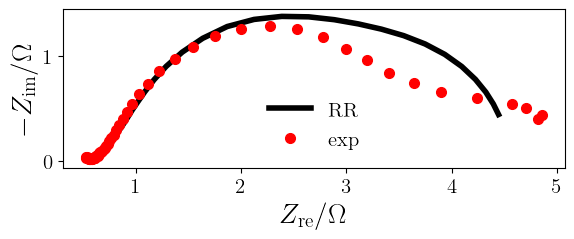

In [ ]:
# Nyquist plots of the exact, experimental, and recovered DRTs
plt.plot(np.real(Z_DRT), -np.imag(Z_DRT), linewidth=4, color='black', label='RR')
plt.plot(np.real(Z_exp), -np.imag(Z_exp), 'o', markersize=7, color='red', label='exp')
plt.legend(frameon=False, fontsize = 15)
plt.axis('scaled')
# plt.xticks(range(0, 90, 20))
# plt.yticks(range(-40, 60, 20))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)

plt.show()

#### 1.10 Save the recovered DRT and impedance

In [ ]:
# # save the DRT recovered with RR
# gamma_DRT_excel = pd.DataFrame(gamma_DRT)
# gamma_DRT_excel.to_csv('./results/1ZARC_DRT-RR.csv',index=False)

# # save the impedance recovered with RR
# df = pd.DataFrame.from_dict({'Freq': freq_vec, 'Real': np.real(Z_DRT), 'Imag': np.imag(Z_DRT)})
# df.to_csv('./results/1ZARC_Z-RR.csv')

### 2. Analysis of multiple EIS spectra

#### 2.1 Load and analyze many EIS spectra concomitantly

In [ ]:
N_exp = 6 # number of EIS experiments

# lists to save the DRTs and impedances
R_inf_DRT_list = [0]*N_exp
L_0_DRT_list = [0]*N_exp
gamma_DRT_list = [0]*N_exp
Z_DRT_list = [0]*N_exp
Z_exp_list = [0]*N_exp


for n in range(N_exp):
    # step 1: load the experimental data
    df = pd.read_csv('E:/Projekte/vertraulich/CMBlu/Jaehyun/script/eval/2ZARC'+str(n)+'.csv') # this artificial data was generated using the 2xZARC model
    N_freqs = df.shape[0]
    freq_vec = np.flip(df['Freq'].values)
    Z_exp = np.flip(df['Real'].values + 1j*df['Imag'].values)
    Z_exp_list[n] = Z_exp
    
    # step 2: compute the epsilon parameter
    epsilon  = basics.compute_epsilon(freq_vec, coeff, rbf_type, shape_control)

    # step 3: compute the differentiation matrices
    A_re = basics.assemble_A_re(freq_vec, tau_vec, epsilon, rbf_type)
    A_re_R_inf = np.ones((N_freqs, 1))
    A_re_L_0 = np.zeros((N_freqs, 1))
    A_re = np.hstack(( A_re_R_inf, A_re_L_0, A_re))
    A_im = basics.assemble_A_im(freq_vec, tau_vec, epsilon, rbf_type)
    A_im_R_inf = np.zeros((N_freqs, 1))
    A_im_L_0 = 2*np.pi*freq_vec.reshape((N_freqs, 1))
    A_im = np.hstack(( A_im_R_inf, A_im_L_0, A_im))
    A = np.vstack((A_re, A_im))
    
    # step 4: compute the differentiation matrix
    M2 = np.zeros((N_taus+2, N_taus+2))
    M2[2:,2:] = basics.assemble_M_2(tau_vec, epsilon, rbf_type)
    
    # step 5: compute the regularization parameter
    # lambda_value = basics.optimal_lambda(A_re, A_im, np.real(Z_exp), np.imag(Z_exp), M2, -3, 'GCV')
    lambda_value = basics.optimal_lambda(A_re, A_im, np.real(Z_exp), np.imag(Z_exp), M2, -3, freq_vec, False, cv_type)
    
    # step 6: recover the DRT
    ### 
    lb = np.zeros([N_taus+2])
    bound_mat = np.eye(lb.shape[0])
    H_combined, c_combined = basics.quad_format_combined(A_re, A_im, np.real(Z_exp), np.imag(Z_exp), M2, lambda_value)
    
    sol = solvers.qp(matrix(H_combined), matrix(c_combined),G,h)
    ## deconvolved DRT
    x = np.array(sol['x']).flatten()
    
    R_inf_DRT_list[n], L_0_DRT_list[n] = x[0:2]
    gamma_DRT_list[n] = x[2:]
    
    # step 7: recover the impedance
    Z_DRT = A@x
    Z_DRT_list[n] = Z_DRT[0:N_freqs] + 1j*Z_DRT[N_freqs:]

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.0530890797452472
            Iterations: 7
            Function evaluations: 14
            Gradient evaluations: 7
GCV
     pcost       dcost       gap    pres   dres
 0: -2.0042e+05 -2.0218e+05  4e+03  9e+00  5e-06
 1: -2.0074e+05 -2.0135e+05  6e+02  9e-02  5e-08
 2: -2.0084e+05 -2.0093e+05  9e+01  1e-02  5e-09
 3: -2.0086e+05 -2.0091e+05  4e+01  2e-03  1e-09
 4: -2.0087e+05 -2.0088e+05  6e+00  2e-04  1e-10
 5: -2.0087e+05 -2.0088e+05  1e+00  1e-05  8e-12
 6: -2.0087e+05 -2.0087e+05  3e-01  2e-06  1e-12
 7: -2.0087e+05 -2.0087e+05  2e-01  1e-06  6e-13
 8: -2.0084e+05 -2.0089e+05  6e+01  9e-15  3e-16
 9: -2.0084e+05 -2.0089e+05  5e+01  2e-14  3e-16
10: -2.0084e+05 -2.0089e+05  5e+01  2e-14  4e-20
11: -2.0085e+05 -2.0088e+05  3e+01  2e-14  2e-20
12: -2.0087e+05 -2.0087e+05  5e+00  3e-14  5e-16
13: -2.0087e+05 -2.0087e+05  7e-01  2e-14  3e-16
14: -2.0087e+05 -2.0087e+05  2e-01  2e-14  2e-16
15: -

#### 2.2 Nyquist plots

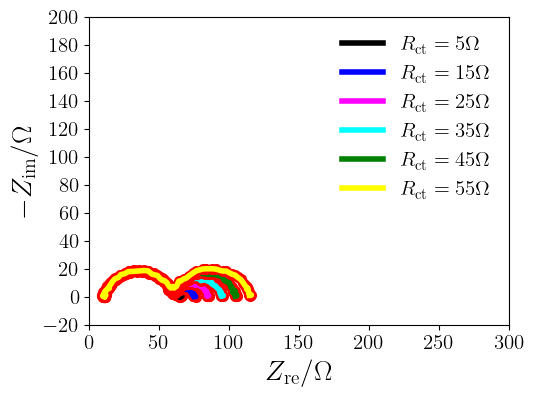

In [ ]:
color_list = ['black', 'blue', 'magenta', 'cyan', 'green', 'yellow']
Rct = [r'$R_{\rm ct}= 5\Omega$',r'$ R_{\rm ct} = 15\Omega$', r'$ R_{\rm ct} = 25\Omega$', r'$ R_{\rm ct} = 35\Omega$', \
       r'$ R_{\rm ct} = 45\Omega$', r'$ R_{\rm ct} = 55\Omega$']
# Nyquist plots of the experimental and regressed impedances
for n in range(N_exp):
    plt.plot(np.real(Z_exp_list[n]), -np.imag(Z_exp_list[n]), 'o', markersize=7, color='red')
    plt.plot(np.real(Z_exp_list[n]), -np.imag(Z_exp_list[n]), linewidth=4, color=color_list[n], label= Rct[n])
plt.legend(frameon=False, fontsize = 15, loc='upper right')
plt.axis('scaled')
plt.xticks(np.arange(0, 300.1, 50))
plt.yticks(np.arange(-20, 200.1, 20))
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(r'$Z_{\rm re}/\Omega$', fontsize = 20)
plt.ylabel(r'$-Z_{\rm im}/\Omega$', fontsize = 20)
fig = plt.gcf()
fig.set_size_inches(6.472, 4)
plt.show()

#### 2.3 DRT plots

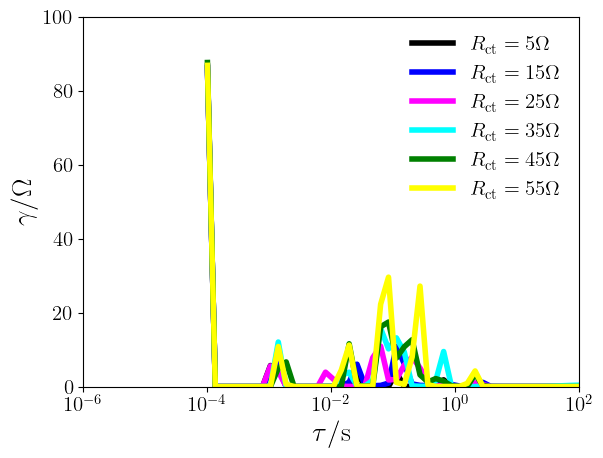

In [ ]:
# Plots of the recovered DRTs
for n in range(N_exp):
    plt.semilogx(tau_vec, gamma_DRT_list[n], linewidth=4, color=color_list[n], label=Rct[n])
plt.legend(frameon=False, fontsize = 15)
plt.axis([1E-6, 1E2, 0, 100])
plt.xlabel(r'$\tau/\rm s$', fontsize = 20)
plt.ylabel(r'$\gamma/\Omega$', fontsize = 20)
fig.set_size_inches(6.472, 4)
plt.savefig('2ZARC_DRT-plots.svg', dpi=300, bbox_inches='tight') # save the picture
plt.savefig('2ZARC_DRT-plots.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### 2.4 Contour plot of the recovered DRTs

FileNotFoundError: [Errno 2] No such file or directory: 'figs/2ZARC_contour-plot.svg'

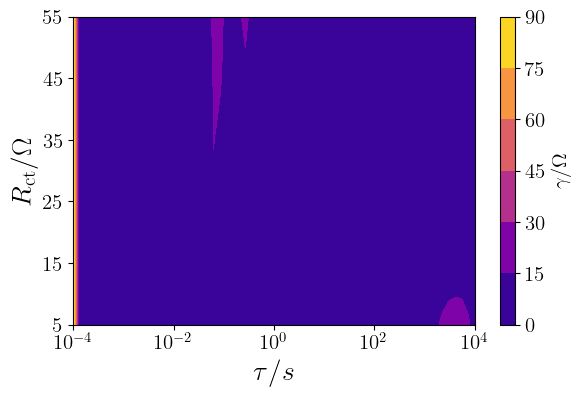

In [ ]:
# Assuming these variables are defined somewhere in your code
N_exp = 6  # Number of experimental conditions

# Custom ticks for the experimental conditions
custom_ticks = [5, 15, 25, 35, 45, 55]

# Generate the necessary matrices for contour plotting
T_range = np.arange(N_exp)  # Experimental condition that varies between one EIS measurement to another
temp_vec = np.array(custom_ticks, dtype=float)  # Use custom ticks as the temperature vector
tau_mat, temp_mat = np.meshgrid(tau_vec, temp_vec)
gamma_norm_global_mat = np.zeros((len(custom_ticks), len(tau_vec)))

for index, temp in enumerate(T_range):
    gamma_norm_global_mat[index, :] = gamma_DRT_list[index]

fig = plt.figure(figsize=(6.472, 4)) 
gs = gridspec.GridSpec(1, 1) 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.5)
ax = plt.subplot(gs[0, 0])
cs = ax.contourf(tau_mat, temp_mat, gamma_norm_global_mat, cmap=plt.cm.plasma)
fig.colorbar(cs, label=r'$\gamma/\Omega$')

# Set custom ticks for the y-axis (experimental conditions)
ax.set_yticks(custom_ticks)

ax.set_ylabel(r'$R_{\rm ct}/\Omega$', fontsize=20)
ax.set_xlabel(r'$\tau/s$', fontsize=20)
ax.set_xscale('log')
fig = plt.gcf()
fig.set_size_inches(6.472, 4)

plt.savefig('figs/2ZARC_contour-plot.svg', dpi=300, bbox_inches='tight')  # save the picture
plt.savefig('figs/2ZARC_contour-plot.pdf', dpi=300, bbox_inches='tight')
plt.show()

#### 2.5 Save the recovered DRTs and impedances

In [ ]:
for n in range(N_exp):
    
    # save the DRT recovered with RR
    gamma_DRT_excel = pd.DataFrame(gamma_DRT_list[n])
    gamma_DRT_excel.to_csv('./results/2ZARC_DRT-RR_'+str(n)+'.csv',index=False)

    # save the impedance recovered with RR
    df = pd.DataFrame.from_dict({'Freq': freq_vec, 'Real': np.real(Z_DRT_list[n]), 'Imag': np.imag(Z_DRT_list[n])})
    df.to_csv('./results/2ZARC_Z-RR_'+str(n)+'.csv')

#### 2.6 Import the recovered DRTs and impedances

In [ ]:
gamma_DRT_list = [0]*N_exp
Z_DRT_list = [0]*N_exp

for n in range(N_exp):
    
    # import the recovered DRTs
    file = open('./results/2ZARC_DRT-RR_'+str(n)+'.csv')
    gamma_DRT_list[n] = loadtxt(file, delimiter = ",")[1:] # because there's a 0 in the first position

    # import the recovered impedances
    df = pd.read_csv('./results/2ZARC_Z-RR_'+str(n)+'.csv') # this artificial data was generated using the 2xZARC model
    Z_DRT = np.flip(df['Real'].values + 1j*df['Imag'].values)
    Z_DRT_list[n] = Z_exp